# 품사 스케일링에 따른 성능 차이
Relation Extraction은 문장 내의 2가지 명사(로 추정되는) entity의 관계를 파악한다. 여기서 문장의 길이는 100에서 400 이상까지 분포하며, 문장의 길이가 학습에 영향을 미칠 수도 있다고 가정한다. 따라서 문장의 길이를 줄이는 목적에서 출발한다. 이 때, 문장 구성 성분 중에서 관계 구분에 대한 영향이 다소 작아 보이는 **형용사 혹은 부사**를 제외한 데이터의 학습 성능을 비교한다.

이를 위해 확인해야하는 사안이 있다.
1. subject_entity와 object_entity에 형용사 및 부사가 포함되지 않았는지
2. sentence에 대해 pos tagging이 잘 수행되는지

품사 스케일링은 다음과 같이 진행한다.
1. 개별 sentence에 대해 pos-tagging을 수행한다.
2. 이 중 형용사, 부사를 문장에서 제거한다
3. 스케일링된 train set으로 baseline을 학습하고 성능을 확인한다.

**<u>삽질을 너무 오래 해서 성능 차이가 유의하면 더 나은 형태소 분석기를 찾아보겠습니다(예: Mecab, Khaiii ...)</u>**

## 1-1. subject & object entity의 품사 확인하기

In [2]:
import matplotlib.font_manager as fm

# 설치된 폰트 출력
font_list = [font.name for font in fm.fontManager.ttflist]
font_list[10:]

['STIXNonUnicode',
 'cmb10',
 'STIXGeneral',
 'DejaVu Sans',
 'STIXGeneral',
 'STIXSizeFourSym',
 'DejaVu Sans',
 'DejaVu Serif',
 'STIXGeneral',
 'DejaVu Sans',
 'cmsy10',
 'DejaVu Serif Display',
 'DejaVu Serif',
 'STIXGeneral',
 'cmtt10',
 'STIXSizeOneSym',
 'STIXNonUnicode',
 'DejaVu Sans Display',
 'DejaVu Sans Mono',
 'STIXSizeFourSym',
 'STIXSizeTwoSym',
 'STIXSizeFiveSym',
 'cmr10',
 'DejaVu Sans Mono',
 'STIXSizeThreeSym',
 'STIXNonUnicode',
 'STIXSizeTwoSym',
 'STIXSizeOneSym']

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from ast import literal_eval
from collections import defaultdict
import warnings

warnings.filterwarnings('ignore')
pd.set_option('display.float_format', lambda x: '%.4f' % x) #4자리까지만

# plt.rcParams['font.family'] = 'NanumGothic' #폰트 나눔고딕 설정

In [97]:
df = pd.read_csv('./dataset/train/train.csv')
test = pd.read_csv('./dataset/test/test_data.csv')
print(test.columns)
df.head()

Index(['id', 'sentence', 'subject_entity', 'object_entity', 'label', 'source'], dtype='object')


,id,sentence,subject_entity,object_entity,label,source
0,0,〈Something〉는 조지 해리슨이 쓰고 비틀즈가 1969년 앨범 《Abbey R...,"{'word': '비틀즈', 'start_idx': 24, 'end_idx': 26...","{'word': '조지 해리슨', 'start_idx': 13, 'end_idx':...",no_relation,wikipedia
1,1,호남이 기반인 바른미래당·대안신당·민주평화당이 우여곡절 끝에 합당해 민생당(가칭)으...,"{'word': '민주평화당', 'start_idx': 19, 'end_idx': ...","{'word': '대안신당', 'start_idx': 14, 'end_idx': 1...",no_relation,wikitree
2,2,K리그2에서 성적 1위를 달리고 있는 광주FC는 지난 26일 한국프로축구연맹으로부터...,"{'word': '광주FC', 'start_idx': 21, 'end_idx': 2...","{'word': '한국프로축구연맹', 'start_idx': 34, 'end_idx...",org:member_of,wikitree
3,3,균일가 생활용품점 (주)아성다이소(대표 박정부)는 코로나19 바이러스로 어려움을 겪...,"{'word': '아성다이소', 'start_idx': 13, 'end_idx': ...","{'word': '박정부', 'start_idx': 22, 'end_idx': 24...",org:top_members/employees,wikitree
4,4,1967년 프로 야구 드래프트 1순위로 요미우리 자이언츠에게 입단하면서 등번호는 8...,"{'word': '요미우리 자이언츠', 'start_idx': 22, 'end_id...","{'word': '1967', 'start_idx': 0, 'end_idx': 3,...",no_relation,wikipedia


In [5]:
df.loc[0,'subject_entity'] 

"{'word': '비틀즈', 'start_idx': 24, 'end_idx': 26, 'type': 'ORG'}"

## 1-2. 품사 태깅 확인

In [98]:
import konlpy
from konlpy.tag import Kkma, Komoran, Okt, Hannanum#, Mecab

# mec = Mecab()
okt = Okt()
kkm = Kkma()
kom = Komoran()
han = Hannanum()

In [99]:
from ast import literal_eval

subject_entity = [literal_eval(entity)['word'] for entity in df['subject_entity']]
object_entity = [literal_eval(entity)['word'] for entity in df['object_entity']]

print(len(subject_entity),len(set(subject_entity)))
print(len(object_entity),len(set(object_entity)))

# print(literal_eval(df.loc[1600,'object_entity']))

32470 12052
32470 10226


- subject와 object는 각각 32,470개
    - subject 고유값은 12,052개
    - object 고유값은 10,226개

In [100]:
subject_entity = list(set(subject_entity))
object_entity = list(set(object_entity))

print(len(subject_entity),len(object_entity))

12052 10226


In [101]:
sample = subject_entity[0]
print(sample)

print(f'Okt의 {sample} 품사 태깅 결과 | {okt.pos(sample)}')
print(f'Komoran의 {sample} 품사 태깅 결과 | {kom.pos(sample)}')
print(f'KKma의 {sample} 품사 태깅 결과 | {kkm.pos(sample)}')
print(f'Hannanum의 {sample} 품사 태깅 결과 | {han.pos(sample)}')

최영호
Okt의 최영호 품사 태깅 결과 | [('최영호', 'Noun')]
Komoran의 최영호 품사 태깅 결과 | [('최영호', 'NNP')]
KKma의 최영호 품사 태깅 결과 | [('최', 'NNP'), ('영호', 'NNG')]
Hannanum의 최영호 품사 태깅 결과 | [('최영호', 'N')]


- 꼬꼬마(KKma)와 한나눔(Hannanum)은 신사임당을 명사로 태깅하지 않았다.

In [102]:
# okt로 해보자
subject_pos = []
subject_wd = [] 
subject_origin = [] #원형 단어
subject_idx = [] #원형 단어의 파생 중 몇 번째인지

for ent in subject_entity:
    poslist = okt.pos(ent,norm=True)
    for idx,(wd,po) in enumerate(poslist):
        # print(tg)
        # wd, po = tg
        subject_origin.append(ent)
        subject_idx.append(idx)
        subject_pos.append(po)
        subject_wd.append(wd)

In [103]:
# okt로 해보자
object_pos = []
object_wd = []
object_origin = []
object_idx = []

for ent in object_entity:
    poslist = okt.pos(ent,norm=True)
    for idx,(wd,po) in enumerate(poslist):
        # print(tg)
        # wd, po = tg
        object_origin.append(ent)
        object_idx.append(idx)
        object_pos.append(po)
        object_wd.append(wd)

In [104]:
subject = pd.DataFrame({'origin':subject_origin,'idx':subject_idx,'word':subject_wd,'pos':subject_pos})
object = pd.DataFrame({'origin':object_origin,'idx':object_idx,'word':object_wd,'pos':object_pos})

tagsets = Okt().tagset
subject["tag"] = subject["pos"].map(tagsets)
object["tag"] = object["pos"].map(tagsets)

subject.head()

,origin,idx,word,pos,tag
0,최영호,0,최영호,Noun,명사
1,발렌시아가,0,발렌시아,Noun,명사
2,발렌시아가,1,가,Josa,조사
3,내셔널 리그,0,내셔널,Noun,명사
4,내셔널 리그,1,리그,Noun,명사


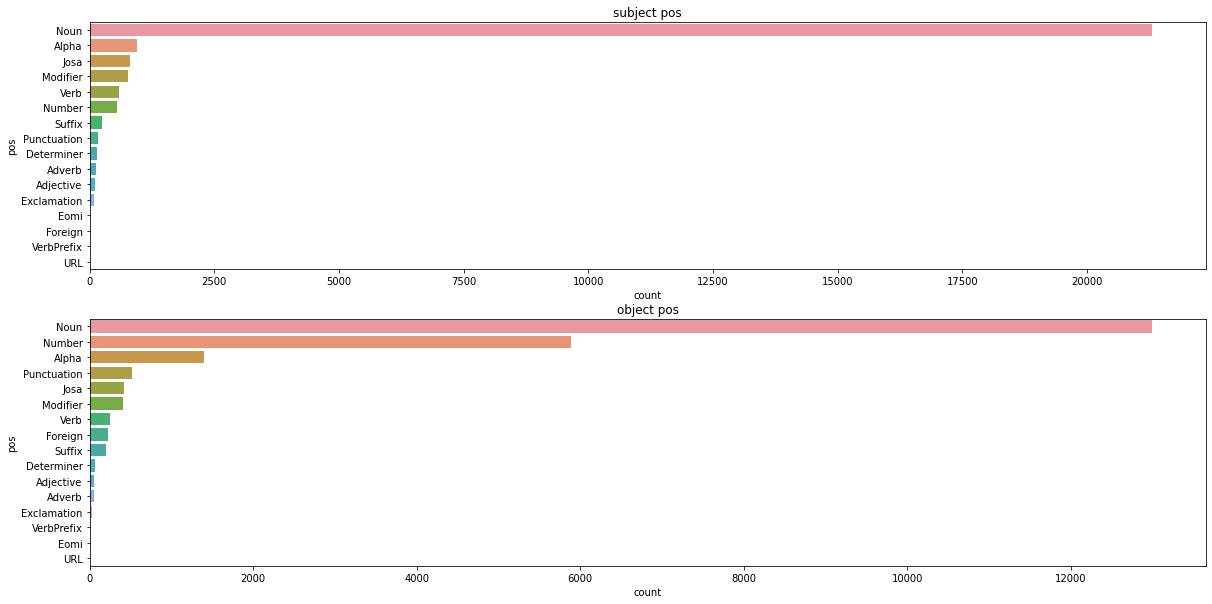

In [13]:
# from collections import Counter

# subject_pos_okt = Counter(subject_pos_okt)
# object_pos_okt = Counter(object_pos_okt)

import seaborn as sns

# plt.figure(figsize=(20,10))
fig, ax = plt.subplots(2,1)
fig.set_size_inches(20,10)

# plt.subplot(2,1,1)
sns.countplot(y='pos',data=subject,order=subject['pos'].value_counts().index,ax=ax[0])
# plt.bar(subject_pos_okt.keys(), subject_pos_okt.values(), width=0.7, edgecolor='black', linewidth=2, color='royalblue')
ax[0].set_title('subject pos')

# plt.subplot(2,1,2)
sns.countplot(y='pos',data=object,order=object['pos'].value_counts().index,ax=ax[1])
# plt.bar(object_pos_okt.keys(), object_pos_okt.values(), width=0.7, edgecolor='black', linewidth=2, color='royalblue')
ax[1].set_title('object pos')

plt.show()

In [14]:
subject['tag'].value_counts()

명사                21314
알파벳                 948
조사                  802
동사                  590
숫자                  544
접미사                 253
구두점                 165
관형사                 143
부사                  136
형용사                 109
감탄사                  90
어미                    8
외국어, 한자 및 기타기호        6
Name: tag, dtype: int64

- 명사가 대부분이지만 형용사/부사인 경우도 존재한다. entity인 경우에는 제거하면 안되기 때문에 처리 시 entity 여부를 확인할 필요가 있다.

## 1-3. 형용사/부사 태깅 확인하기

In [15]:
subject[subject['tag']=='형용사']

,origin,idx,word,pos,tag
264,아슈라프 하키미,2,미,Adjective,형용사
300,미 해병1사단,0,미,Adjective,형용사
571,미야와키 사쿠라,0,미야와,Adjective,형용사
981,제이크 디크먼,3,먼,Adjective,형용사
1214,미쓰이 히사시,0,미,Adjective,형용사
...,...,...,...,...,...
25256,제164전구비행장작전단,5,작전단,Adjective,형용사
25348,케텔 마르테,1,마르테,Adjective,형용사
25515,호르헤 부르차가,2,차가,Adjective,형용사
25706,안여린,1,여린,Adjective,형용사


- 대부분 **고유명사**같이 VOCAB에 포함되지 않은 명사를 잘못 태깅한 케이스가 많았다. entity의 경우, 제거 대상으로 포함하지 않으므로 문제가 없지만 문장 내에 중요한 정보를 포함하는 고유명사가 형용사/부사로 잘못 태깅되고-->이에 따라 잘못된 문장이 생성될 수도 있다.
- 지금은 단어 단위로 태깅했는데, **문장 단위로 태깅할 때도 동일한 문제가 발생할까?** 확인할 필요가 있다

In [16]:
subject[subject['tag']=='부사']

,origin,idx,word,pos,tag
451,에리히 리베크,1,히,Adverb,부사
634,우에하라 고지,0,우,Adverb,부사
827,요앙 왈랭,1,앙,Adverb,부사
842,히브리 대학,0,히,Adverb,부사
946,US-방글라 항공,2,방글,Adverb,부사
...,...,...,...,...,...
24870,야마시타 토모히사,2,히,Adverb,부사
24893,엔도 야스히토,2,히,Adverb,부사
25281,후이 파트리시우,4,우,Adverb,부사
25303,세르히오 로메로,1,히,Adverb,부사


In [105]:
subject[subject['tag']=='관형사']

,origin,idx,word,pos,tag
76,다이앤 레인,1,이,Determiner,관형사
114,이대열,0,이,Determiner,관형사
974,마르그레테 2세,1,그,Determiner,관형사
1011,한성여객,0,한,Determiner,관형사
1041,한양대학교,0,한,Determiner,관형사
...,...,...,...,...,...
25033,그레고르 멘델,0,그,Determiner,관형사
25329,마르그레테 1세,1,그,Determiner,관형사
25545,이기정,0,이,Determiner,관형사
25775,주월한국군사원조단,2,한,Determiner,관형사


- 부사도 마찬가지로 외국어/외래어/기타 한국어 고유명사를 인식하지 못하고 부사로 처리한 케이스가 많아 보인다.

### 1-3-1. 문장 단위 태깅
1. 고유 명사가 형용사/부사로 잘못 태깅되는 경우가 있다.
2. 문장 전체를 태깅해도 동일한 문제가 발생하는지 확인한다

In [51]:
# subject_entity & object_entity 칼럼화

# df['subject_word'] = [literal_eval(entity)['word'] for entity in df['subject_entity']]
# df['subject_stt_idx'] = [literal_eval(entity)['start_idx'] for entity in df['subject_entity']]
# df['subject_end_idx'] = [literal_eval(entity)['end_idx'] for entity in df['subject_entity']]
# df['subject_type'] = [literal_eval(entity)['type'] for entity in df['subject_entity']]

# df['object_word'] = [literal_eval(entity)['word'] for entity in df['object_entity']]
# df['object_stt_idx'] = [literal_eval(entity)['start_idx'] for entity in df['object_entity']]
# df['object_end_idx'] = [literal_eval(entity)['end_idx'] for entity in df['object_entity']]
# df['object_type'] = [literal_eval(entity)['type'] for entity in df['object_entity']]

# df.to_csv('./dataset/train/train_eval.csv',index=False,encoding='utf-8')
df = pd.read_csv('./dataset/train/train_eval.csv')
df.head()

,id,sentence,subject_entity,object_entity,label,source,subject_word,subject_stt_idx,subject_end_idx,subject_type,object_word,object_stt_idx,object_end_idx,object_type
0,0,〈Something〉는 조지 해리슨이 쓰고 비틀즈가 1969년 앨범 《Abbey R...,"{'word': '비틀즈', 'start_idx': 24, 'end_idx': 26...","{'word': '조지 해리슨', 'start_idx': 13, 'end_idx':...",no_relation,wikipedia,비틀즈,24,26,ORG,조지 해리슨,13,18,PER
1,1,호남이 기반인 바른미래당·대안신당·민주평화당이 우여곡절 끝에 합당해 민생당(가칭)으...,"{'word': '민주평화당', 'start_idx': 19, 'end_idx': ...","{'word': '대안신당', 'start_idx': 14, 'end_idx': 1...",no_relation,wikitree,민주평화당,19,23,ORG,대안신당,14,17,ORG
2,2,K리그2에서 성적 1위를 달리고 있는 광주FC는 지난 26일 한국프로축구연맹으로부터...,"{'word': '광주FC', 'start_idx': 21, 'end_idx': 2...","{'word': '한국프로축구연맹', 'start_idx': 34, 'end_idx...",org:member_of,wikitree,광주FC,21,24,ORG,한국프로축구연맹,34,41,ORG
3,3,균일가 생활용품점 (주)아성다이소(대표 박정부)는 코로나19 바이러스로 어려움을 겪...,"{'word': '아성다이소', 'start_idx': 13, 'end_idx': ...","{'word': '박정부', 'start_idx': 22, 'end_idx': 24...",org:top_members/employees,wikitree,아성다이소,13,17,ORG,박정부,22,24,PER
4,4,1967년 프로 야구 드래프트 1순위로 요미우리 자이언츠에게 입단하면서 등번호는 8...,"{'word': '요미우리 자이언츠', 'start_idx': 22, 'end_id...","{'word': '1967', 'start_idx': 0, 'end_idx': 3,...",no_relation,wikipedia,요미우리 자이언츠,22,30,ORG,1967,0,3,DAT


In [ ]:
# subject_entity가 '니콜 키드먼'인 문장
okt.pos(df.loc[df['subject_word']=='니콜 키드먼','sentence'].values[0])
# df.loc[df['subject_word']=='니콜 키드먼','sentence'].values[0]

[('또한', 'Noun'),
 ('영화배우', 'Noun'),
 ('톰', 'Noun'),
 ('크루즈', 'Noun'),
 ('(', 'Punctuation'),
 ('Tom', 'Alpha'),
 ('Cruise', 'Alpha'),
 ('),', 'Punctuation'),
 ('니콜', 'Noun'),
 ('키드', 'Noun'),
 ('먼', 'Adjective'),
 ('(', 'Punctuation'),
 ('Nicole', 'Alpha'),
 ('Kidman', 'Alpha'),
 (')', 'Punctuation'),
 ('이', 'Noun'),
 ('출연', 'Noun'),
 ('했으나', 'Verb'),
 ('흥행', 'Noun'),
 ('은', 'Josa'),
 ('저조했던', 'Adjective'),
 ('자동차', 'Noun'),
 ('경주', 'Noun'),
 ('영화', 'Noun'),
 ('《', 'Foreign'),
 ('Days', 'Alpha'),
 ('of', 'Alpha'),
 ('Thunder', 'Alpha'),
 ('》', 'Foreign'),
 ('의', 'Noun'),
 ('OST', 'Alpha'),
 ('에는', 'Josa'),
 ('Knockin', 'Alpha'),
 ("'", 'Punctuation'),
 ('on', 'Alpha'),
 ('Heaven', 'Alpha'),
 ("'", 'Punctuation'),
 ('s', 'Alpha'),
 ('Door', 'Alpha'),
 (',', 'Punctuation'),
 ('천국', 'Noun'),
 ('의', 'Josa'),
 ('문', 'Noun'),
 ('을', 'Josa'),
 ('두드리며', 'Verb'),
 ('〉', 'Foreign'),
 ('가', 'Verb'),
 ('들어', 'Verb'),
 ('있다', 'Adjective'),
 ('.', 'Punctuation'),
 ('이어', 'Verb'),
 ('다음', 'Noun'),
 (

- 문장 전체로 품사 태깅을 해도 동일한 문제가 발생한다. entity인 '니콜 키드먼'을 '니콜(명사)','키드(명사)','먼(형용사)'로 인식한다.
- 그리고 '니콜 키드먼(Nicole Kidman)'뒤에 이어지는 '이'도 조사로 인식하지 못한다.(형용사 처리를 하지 않아서 문제 되지는 않지만, 형용사로 인식될 가능성도 배제할 수 없다)
- 다른 인식기에서도 동일한 오류가 발생할까?

In [ ]:
kkm.pos(df.loc[df['subject_word']=='니콜 키드먼','sentence'].values[0])[:15]

[('또한', 'MAG'),
 ('영화배우', 'NNG'),
 ('톰', 'UN'),
 ('크루즈', 'NNG'),
 ('(', 'SS'),
 ('Tom', 'OL'),
 ('Cruise', 'OL'),
 (')', 'SS'),
 (',', 'SP'),
 ('니콜', 'NNG'),
 ('키드', 'NNG'),
 ('멀', 'VA'),
 ('ㄴ', 'ETD'),
 ('(', 'SS'),
 ('Nicole', 'OL')]

꼬고마(Kkma)도 okt와 비슷한 태깅 결과를 보인다. '톰 크루즈'나 '니콜 키드먼'을 고유명사로서 하나의 단어로 인식하지 못한 것

In [ ]:
kom.pos(df.loc[df['subject_word']=='니콜 키드먼','sentence'].values[0])[:15]

[('또한', 'MAJ'),
 ('영화배우', 'NNP'),
 ('톰 크루즈', 'NNP'),
 ('(', 'SS'),
 ('Tom', 'SL'),
 ('Cruise', 'SL'),
 (')', 'SS'),
 (',', 'SP'),
 ('니콜 키드먼', 'NNP'),
 ('(', 'SS'),
 ('Nicole', 'SL'),
 ('Kidman', 'SL'),
 (')', 'SS'),
 ('이', 'MM'),
 ('출연', 'NNG')]

코모란(Komoran)은 '톰 크루즈'와 '니콜 키드먼'을 하나의 명사로 인식한다.

In [ ]:
han.pos(df.loc[df['subject_word']=='니콜 키드먼','sentence'].values[0])[:15]

[('또한', 'M'),
 ('영화배우', 'N'),
 ('톰', 'N'),
 ('크루즈(Tom', 'N'),
 ('Cruise', 'F'),
 ('),', 'S'),
 ('니콜', 'N'),
 ('키드먼(Nicole', 'N'),
 ('Kidman', 'F'),
 (')', 'S'),
 ('이', 'J'),
 ('출연', 'N'),
 ('하', 'X'),
 ('었으나', 'E'),
 ('흥행', 'N')]

한나눔은 '톰 크루즈'를 하나의 단어가 아닌 '톰'과 '크루즈' 2개로 쪼개서 인식했지만, 명사로 처리한다.
- **원 문장의 relation은 무엇이었을까?**

In [ ]:
df.loc[df['subject_word']=='니콜 키드먼',['sentence','subject_word','subject_type','object_word','object_type','label']]

,sentence,subject_word,subject_type,object_word,object_type,label
11708,"또한 영화배우 톰 크루즈(Tom Cruise), 니콜 키드먼(Nicole Kidma...",니콜 키드먼,PER,톰 크루즈,PER,per:colleagues


- https://wikidocs.net/92961 에 따르면 konlpy의 분석기에 (새로운 단어, 품사) 형태로 사전에 단어를 추가하는 customizing이 가능하다고 한다. 이에 따라 entity 중에서 type이 per이거나 org인 경우, 하나의 명사로 추가하여 tagger를 customizing 해본다

In [23]:
from konlpy.tag import Twitter
twt = Twitter()

twt.pos(df.loc[df['subject_word']=='니콜 키드먼','sentence'].values[0])[:15]

[('또한', 'Noun'),
 ('영화배우', 'Noun'),
 ('톰', 'Noun'),
 ('크루즈', 'Noun'),
 ('(', 'Punctuation'),
 ('Tom', 'Alpha'),
 ('Cruise', 'Alpha'),
 ('),', 'Punctuation'),
 ('니콜', 'Noun'),
 ('키드', 'Noun'),
 ('먼', 'Adjective'),
 ('(', 'Punctuation'),
 ('Nicole', 'Alpha'),
 ('Kidman', 'Alpha'),
 (')', 'Punctuation')]

- **어떤 분석기를 쓰느냐에 따라 성능이 달라질 수 있기 때문에, 분석기별로 각각 문장 처리를 수행한다** (okt, kkm, kom, han 4가지)
- [참고](https://wikidocs.net/92961)에 따르면 customized_konlpy로 사전에 새로운 단어와 태깅을 추가할 수 있다고 한다.(단, Twitter만)
- corpus 비지도 학습을 통해 토큰화를 수행하는 soynlp도 사용해볼 수 있다.

### 1-4. soynlp 학습

In [106]:
!pip install soynlp

     |████████████████████████████████| 416 kB 15.2 MB/s eta 0:00:01


#### 예제

In [107]:
import urllib.request
from soynlp import DoublespaceLineCorpus
from soynlp.word import WordExtractor

In [108]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/lovit/soynlp/master/tutorials/2016-10-20.txt", filename="2016-10-20.txt")

('2016-10-20.txt', <http.client.HTTPMessage at 0x7f4b3edcf190>)

In [109]:
corpus = DoublespaceLineCorpus("2016-10-20.txt")
len(corpus)

30091

In [111]:
for document in corpus:
  if len(document) > 0:
    print(document)
    break

19  1990  52 1 22


In [112]:
word_extractor = WordExtractor()
word_extractor.train(corpus)
word_score_table = word_extractor.extract()

training was done. used memory 2.335 Gb
all cohesion probabilities was computed. # words = 223348
all branching entropies was computed # words = 361598
all accessor variety was computed # words = 361598


#### 예제처럼 코퍼스 만들기

#### 삽질의 흔적

In [ ]:
# ! apt-get install -y build-essential openjdk-8-jdk python3-dev curl git automake
# ! pip install konlpy "tweepy<4.0.0"
# ! /bin/bash <(curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh)

In [96]:
!pip install --upgrade pip
# !pip install JPype1-1.3.0-cp38-cp38-win32.whl
!pip install konlpy

# !pip install konlpy
# !bash <curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh

ERROR: JPype1-1.3.0-cp38-cp38-win32.whl is not a supported wheel on this platform.


In [71]:
os.environ['JAVA_HOME'] = '/opt/conda/bin/java'
os.getenv('JAVA_HOME')

'/opt/conda/bin/java'

In [ ]:
# khaiii 설치
# !pip install cmake

## 2. 형용사 및 부사 제거된 문장 만들기
품사 스케일링은 다음과 같이 진행한다.
1. 개별 sentence에 대해 pos-tagging을 수행한다.(분석기 4가지 버전으로)
2. 이 중 형용사, 부사를 문장에서 제거한다. 단, entity는 제외
3. 형용사와 부사를 제거한 토큰을 이어 붙인다. 이 때, 띄어쓰기가 손상되었을 가능성이 있으므로 띄어쓰기 보정을 추가한다(옵션)
3. 스케일링된 train set으로 baseline을 학습하고 성능을 확인한다.

In [14]:
# df = pd.read_csv('./dataset/train/train_eval.csv')
# df.head()

In [ ]:
# df.iloc[0,:]['subject_entity']

"{'word': '비틀즈', 'start_idx': 24, 'end_idx': 26, 'type': 'ORG'}"

라이브러리 준비

In [ ]:
# !pip install git+https://github.com/haven-jeon/PyKoSpacing.git #PyKoSpacing(딥러닝 코퍼스 학습 기반)-->에러떠서 바로 바꿈
# !pip install git+https://github.com/ssut/py-hanspell.git #Py-Hanspell(네이버 맞춤법 검사기 기반)

In [ ]:
# !pip install google
# !pip3 install protobuf
# !conda install protobuf

In [6]:
import pandas as pd
# import matplotlib.pyplot as plt
import numpy as np
# import seaborn as sns
from ast import literal_eval
from collections import defaultdict, Counter
import warnings

from tqdm.auto import trange
from time import sleep

# from pykospacing import Spacing
from hanspell import spell_checker

from konlpy.tag import Okt, Komoran, Kkma, Hannanum

warnings.filterwarnings('ignore')
pd.set_option('display.float_format', lambda x: '%.4f' % x) #4자리까지만

# plt.rcParams['font.family'] = 'NanumGothic' #폰트 나눔고딕 설정

/opt/conda/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


전처리 함수 모음

In [7]:
# label 개수를 기준으로 증강에서 제외할 exc_label
# def except_label(dataset,column='label',limit=200):
#     """label 개수를 기준으로 증강에서 제외할 label 출력
#     dataset: pd.dataframe
#     column: str |--> 기준이 되는 칼럼
#     limit: int |-->label 개수"""
    
#     df_cnt = pd.DataFrame(dataset['label'].value_counts())
#     df_cnt = df_cnt.reset_index(drop=False)
#     df_cnt.columns = ['label','count']
#     # print(df_cnt.head())
#     exc_label = df_cnt.loc[df_cnt['count']>limit,'label']
#     exc_label = list(exc_label)
#     return exc_label

# limit 이하의 개수인 label만 포함하는 데이터프레임 출력
def accept_label(dataset,limit=200):
    """except label이 아닌 label(relation) 문장만 포함한 데이터프레임 출력"""
    # ver 1. dataframe
    # df_cnt = pd.DataFrame(dataset['label'].value_counts())
    # df_cnt = df_cnt.reset_index(drop=False)
    # df_cnt.columns = ['label','count']
    # # print(df_cnt.head())
    # acc_label = df_cnt.loc[df_cnt['count']<=limit,'label']
    # acc_label = list(acc_label)
    
    # ver 2. counter
    
    df_cnt = Counter(dataset['label'])
    acc_label = [label for idx,label in enumerate(df_cnt) if df_cnt[label]<=limit]
    print(len(acc_label))

    # labels = dataset.loc[:,'label']
    # idx_label = [idx for idx,label in enumerate(labels) if label not in acc_label]
    # print(len(dataset),len(idx_label))
    
    df = dataset.loc[dataset['label'].isin(acc_label),:]
    df = df.reset_index(drop=True)
    return df

# entity-->>word, stt_idx, end_idx, type으로 쪼개기
def eval_entity(df):
    """딕셔너리 형태의 entity를 쪼개 word, stt_idx, end_idx, type을 각각 칼럼으로 추가하는 함수"""

    df['subject_word'] = [literal_eval(entity)['word'] for entity in df['subject_entity']]
    df['subject_stt_idx'] = [literal_eval(entity)['start_idx'] for entity in df['subject_entity']]
    df['subject_end_idx'] = [literal_eval(entity)['end_idx'] for entity in df['subject_entity']]
    df['subject_type'] = [literal_eval(entity)['type'] for entity in df['subject_entity']]

    df['object_word'] = [literal_eval(entity)['word'] for entity in df['object_entity']]
    df['object_stt_idx'] = [literal_eval(entity)['start_idx'] for entity in df['object_entity']]
    df['object_end_idx'] = [literal_eval(entity)['end_idx'] for entity in df['object_entity']]
    df['object_type'] = [literal_eval(entity)['type'] for entity in df['object_entity']]
    print(df.columns)
    return df
    
# subject_entity의 stt_idx와 object entity의 stt_idx에 각각 토큰 집어넣기
def tokenize_entity(sentence,sub_idx,ob_idx):
    """문장을 subject, object의 토큰으로 치환하는 함수
    sentence: str |-->input 문장
    sub_idx: list(stt,end) |-->subject 인덱스
    ob_idx: list(stt,end) |-->object 인덱스"""
    sub_stt, sub_end = sub_idx
    ob_stt, ob_end = ob_idx
    
    if sub_stt < ob_stt: # sub가 ob보다 앞에 있을 때
        sentence = sentence[:sub_stt]+'subject'+sentence[sub_end+1:]
        l = 7 - (sub_end-sub_stt+1)
        ob_stt += l
        ob_end += l
        sentence = sentence[:ob_stt]+'object'+sentence[ob_end+1:]
    else:
        sentence = sentence[:ob_stt]+'subject'+sentence[ob_end+1:]
        l = 7 - (ob_end-ob_stt+1)
        sub_stt += l
        sub_end += l
        sentence = sentence[:sub_stt]+'object'+sentence[sub_end+1:]
    return sentence

# 토큰화 문장을 태깅하고 형용사/부사를 제거하는 함수
def PosTag_token(sentence,tag='okt',drop_pos=['Adjective','Adverb'],norm=True,pacing=True):
    """문장을 태깅 후 성분 제거하는 함수
    sentence: pd.Series |-->idx기반 dataframe의 행"""

    taggers = {'okt':Okt(), 'kom':Komoran(), 'kkm':Kkma(), 'han':Hannanum()}
    tagg = taggers[tag]
    sentence_pos = tagg.pos(sentence,norm=norm)
    result = []
    drop = False

    for idx,(word,pos) in enumerate(sentence_pos):
        if pos in drop_pos:
            drop=True
            continue
        else:
            result.append(word)

    if not drop:
        return result, drop

    #띄어쓰기 보정
    elif pacing:
        result = ''.join(result)

        # spacing = Spacing()
        # result = spacing(result)
        
        spelled_sent = spell_checker.check(result)
        result = spelled_sent.checked

        #subject, object 보정
        if result.find('subject')<0:
            for i in range(1,7):
                sub = 'subject'
                sub = sub[:i] + ' ' + sub[i:]
                if result.find(sub)!=-1:
                    result = result.replace(sub,'subject')
        if result.find('object')<0:
            for i in range(1,6):
                ob = 'object'
                ob = ob[:i] + ' ' +ob[i:]
                if result.find(ob)!=-1:
                    result = result.replace(ob,'object')
            # if result.find('o bject')>=0:
            #     result = result.replace('o bject','object')
            # elif result.find('ob ject')>=0:
            #     result = result.replace('ob ject','object')
            # elif result.find('obj ect')>=0:
            #     result = result.replace('obj ect','object')
            # elif result.find('obje ct')>=0:
            #     result = result.replace('obje ct','object')
            # elif result.find('objec t')>=0:
            #     result = result.replace('objec t','object')
        
    else:
        result = ' '.join(result)
    return result,drop

# 토큰 다시 치환하기
def back_tokenize(sentence,subject_word,object_word):
    """subject, object 토큰을 원래 단어로 치환하는 함수"""
    if sentence.find('subject')<sentence.find('object'): #sub가 앞에 있을 때
        sub_stt_idx = sentence.find('subject')
        sub_end_idx = sub_stt_idx+len(subject_word)-1
        ob_stt_idx = sentence.find('object') - (7-len(subject_word))
        ob_end_idx = ob_stt_idx+len(object_word)-1
    else:
        ob_stt_idx = sentence.find('object')
        ob_end_idx = ob_stt_idx+len(object_word)-1
        sub_stt_idx = sentence.find('subject') - (7-len(object_word))
        sub_end_idx = sub_stt_idx+len(subject_word)-1
        
    # subject = sentence.split('subject')
    # if len(subject)!=2:
    #     return print(subject)
    # else:
    #     subject_pre,subject_end = subject#sentence.split('subject')
    #     result = subject_pre+subject_word+subject_end
    subject_pre,subject_end = sentence.split('subject')
    result = subject_pre+subject_word+subject_end

    # object = result.split('object')
    # if len(object)!=2:
    #     return print(object)
    # else:
    #     object_pre,object_end = object #result.split('object')
    #     result = object_pre+object_word+object_end
    object_pre,object_end = result.split('object')
    result = object_pre+object_word+object_end

    return result, sub_stt_idx, sub_end_idx, ob_stt_idx, ob_end_idx

# 데이터프레임 처리
def pos_augmentation(data,exc_limit=200,tag='okt',drop_pos=['Adjective','Adverb'],norm=True,pacing=True):
    """데이터프레임 전처리"""
    
    # exc_label = except_label(data,limit=exc_limit)
    dataset = accept_label(data,limit=exc_limit)
    dataset = eval_entity(dataset)

    new_sentences = []
    new_sub_entity = []
    new_ob_entity = []
    new_labels = []
    new_sources = []

    #'id', 'sentence', 'subject_entity', 'object_entity', 'label', 'source',
    #    'subject_word', 'subject_stt_idx', 'subject_end_idx', 'subject_type',
    #    'object_word', 'object_stt_idx', 'object_end_idx', 'object_type'

    for i in trange(len(dataset)):
        # sent = dataset.loc[i,'sentence']
        # sub_wd,sub_stt,sub_end,sub_type = dataset.loc[i,['subject_word','subject_stt_idx','subject_end_idx','subject_type']]
        # ob_wd,ob_stt,ob_end,ob_type = dataset.loc[i,['object_word','object_stt_idx','object_end_idx','object_type']]
        # label = dataset.loc[i,'label']
        # source = dataset.loc[i,'source']

        _,sent,_,_,label,source,sub_wd,sub_stt,sub_end,sub_type,ob_wd,ob_stt,ob_end,ob_type = dataset.iloc[i,:]

        new_sent = tokenize_entity(sent,[sub_stt,sub_end],[ob_stt,ob_end])
        new_sent,drop = PosTag_token(new_sent,tag=tag,drop_pos=drop_pos,norm=norm,pacing=pacing)
        if drop: #drop_pos 적용한 케이스
            new_sent,sub_stt,sub_end,ob_stt,ob_end = back_tokenize(new_sent,sub_wd,ob_wd)
            new_sentences.append(new_sent)
            new_sub_entity.append(str({'word':sub_wd,'start_idx':sub_stt,'end_idx':sub_end,'type':sub_type}))
            new_ob_entity.append(str({'word':ob_wd,'start_idx':ob_stt,'end_idx':ob_end,'type':ob_type}))
            new_labels.append(label)
            new_sources.append(source)
        else:
            continue
        sleep(0.01)


    add_rows = len(new_sentences)
    ids = list(range(len(data),len(data)+add_rows))
    
    new_df = pd.DataFrame({ 'id':ids,
                            'sentence':new_sentences,
                            'subject_entity':new_sub_entity,
                            'object_entity':new_ob_entity,
                            'label':new_labels,
                            'source':new_sources})

    return new_df  
    

예제 모음

In [10]:
# except_label 예제
# sample = pd.read_csv('./dataset/train/train.csv')
# except_label(sample,limit=200)

['per:place_of_residence',
 'per:other_family',
 'per:place_of_birth',
 'org:founded_by',
 'per:product',
 'per:siblings',
 'org:political/religious_affiliation',
 'per:religion',
 'per:schools_attended',
 'org:dissolved',
 'org:number_of_employees/members',
 'per:place_of_death']

In [48]:
# accept_label 예제
df = accept_label(train) # 12 #32470 / 31061
# df['label'].value_counts()
# df.head()

12


In [61]:
os.path.join('./dataset/train','sample'+'.csv')

'./dataset/train/sample.csv'

In [38]:
# eval_entity 예제
df = eval_entity(train)

Index(['id', 'sentence', 'subject_entity', 'object_entity', 'label', 'source',
       'subject_word', 'subject_stt_idx', 'subject_end_idx', 'subject_type',
       'object_word', 'object_stt_idx', 'object_end_idx', 'object_type'],
      dtype='object')


In [15]:
# tokenize_entity 예제
sample = df.loc[0,'sentence']
print(sample)

sam_sub = df.loc[0,['subject_stt_idx','subject_end_idx']]
sam_ob = df.loc[0,['object_stt_idx','object_end_idx']]

tokenize_entity(sample,sam_sub,sam_ob)

〈Something〉는 조지 해리슨이 쓰고 비틀즈가 1969년 앨범 《Abbey Road》에 담은 노래다.


'〈Something〉는 subject이 쓰고 object가 1969년 앨범 《Abbey Road》에 담은 노래다.'

In [ ]:
# PosTag_token 예제 - 띄어쓰기 보정이 필요하다
sample = tokenize_entity(sample,sam_sub,sam_ob)
PosTag_token(sample)

In [17]:
# back_tokenize 예제
sample,tf = PosTag_token(sample)
back_tokenize(sample,'조지 해리슨','비틀즈')

('〈 Som ething〉는 조지 해리슨이 쓰고 비틀즈가 1969년 앨범 《 AbbeyRoad》에 담은 노래다.',
 15,
 20,
 26,
 28)

최종 점검

In [10]:
# pos_augmentation 예제
sample = pd.read_csv('./dataset/train/train.csv')
# test = pd.read_csv('./dataset/test/test_data.csv')
pos_augmentation(sample.head(1000),exc_limit=50,pacing=False) #137 중 81번째에서 에러 발생

25
Index(['id', 'sentence', 'subject_entity', 'object_entity', 'label', 'source',
       'subject_word', 'subject_stt_idx', 'subject_end_idx', 'subject_type',
       'object_word', 'object_stt_idx', 'object_end_idx', 'object_type'],
      dtype='object')


  0%|          | 2/428 [00:04<15:46,  2.22s/it]


KeyboardInterrupt: 

In [10]:
# sample = '이건 정말 대단한 문장입니다'
# from konlpy.tag import Okt
# okt = Okt()
# sample = okt.pos(sample)
for idx,(word,pos) in enumerate(sample):
    print(word)

이건
정말
대단한
문장
입니다


In [28]:
for i in range(len(df)):
    sub = df.loc[i,'subject_stt_idx']
    ob = df.loc[i,'object_stt_idx']
    if sub>ob:
        print(i,'subject가 항상 앞에 위치하는 건 아니다')
        print(df.loc[i,['sentence','subject_word','object_word']])
        break

0 subject가 항상 앞에 위치하는 건 아니다
sentence        〈Something〉는 조지 해리슨이 쓰고 비틀즈가 1969년 앨범 《Abbey R...
subject_word                                                  비틀즈
object_word                                                조지 해리슨
Name: 0, dtype: object


## 3. Baseline 학습을 위한 전체 데이터셋 만들기

In [81]:
train = pd.read_csv('./dataset/train/train.csv')
train.loc[:,'label'].value_counts().tail(13)

per:children                           304
per:place_of_residence                 193
per:other_family                       190
per:place_of_birth                     166
org:founded_by                         155
per:product                            139
per:siblings                           136
org:political/religious_affiliation     98
per:religion                            96
per:schools_attended                    82
org:dissolved                           66
org:number_of_employees/members         48
per:place_of_death                      40
Name: label, dtype: int64

200 기준

In [54]:
train_aug = pos_augmentation(train,exc_limit=200,pacing=False)

12
Index(['id', 'sentence', 'subject_entity', 'object_entity', 'label', 'source',
       'subject_word', 'subject_stt_idx', 'subject_end_idx', 'subject_type',
       'object_word', 'object_stt_idx', 'object_end_idx', 'object_type'],
      dtype='object')


100%|██████████| 1409/1409 [34:56<00:00,  1.49s/it]


In [74]:
train_aug['label'].value_counts()

per:place_of_residence                 95
org:founded_by                         85
per:other_family                       75
per:siblings                           71
per:product                            69
per:religion                           56
org:political/religious_affiliation    52
per:place_of_birth                     52
per:schools_attended                   42
org:number_of_employees/members        37
org:dissolved                          36
per:place_of_death                     12
Name: label, dtype: int64

In [75]:
train_aug.to_csv('./dataset/train/train_aug_pos200.csv',index=False,encoding='utf-8')

In [91]:
result200 = pd.concat([train,train_aug],axis=0).reset_index(drop=True)
result200['label'].value_counts()

no_relation                            9534
org:top_members/employees              4284
per:employee_of                        3573
per:title                              2103
org:member_of                          1866
org:alternate_names                    1320
per:origin                             1234
org:place_of_headquarters              1195
per:date_of_birth                      1130
per:alternate_names                    1001
per:spouse                              795
per:colleagues                          534
per:parents                             520
org:founded                             450
org:members                             420
per:date_of_death                       418
org:product                             380
per:children                            304
per:place_of_residence                  288
per:other_family                        265
org:founded_by                          240
per:place_of_birth                      218
per:product                     

In [92]:
result200.to_csv('./dataset/train/train_pos200.csv',index=False,encoding='utf-8')

In [93]:
print(len(result200))
result200.tail(1)

33152


,id,sentence,subject_entity,object_entity,label,source
33151,33151,"그러나 김양상 의 친형 제로 보기 는 사촌 형제 라고 보기 도 , 이는 삼국사기 ,...","{'word': '원성왕', 'start_idx': 65, 'end_idx': 67...","{'word': '선덕왕', 'start_idx': 74, 'end_idx': 76...",per:other_family,wikipedia


400 기준

In [56]:
train_aug_400 = pos_augmentation(train,exc_limit=400,pacing=False)

14
Index(['id', 'sentence', 'subject_entity', 'object_entity', 'label', 'source',
       'subject_word', 'subject_stt_idx', 'subject_end_idx', 'subject_type',
       'object_word', 'object_stt_idx', 'object_end_idx', 'object_type'],
      dtype='object')


100%|██████████| 2093/2093 [52:23<00:00,  1.50s/it]


In [69]:
train_aug_400.to_csv('./dataset/train/train_aug_pos400.csv',index=False,encoding='utf-8')
train_aug_400['label'].value_counts()

org:product                            193
per:children                           136
per:place_of_residence                  95
org:founded_by                          85
per:other_family                        75
per:siblings                            71
per:product                             69
per:religion                            56
org:political/religious_affiliation     52
per:place_of_birth                      52
per:schools_attended                    42
org:number_of_employees/members         37
org:dissolved                           36
per:place_of_death                      12
Name: label, dtype: int64

In [94]:
result400 = pd.concat([train,train_aug_400],axis=0).reset_index(drop=True)
result400['label'].value_counts()

no_relation                            9534
org:top_members/employees              4284
per:employee_of                        3573
per:title                              2103
org:member_of                          1866
org:alternate_names                    1320
per:origin                             1234
org:place_of_headquarters              1195
per:date_of_birth                      1130
per:alternate_names                    1001
per:spouse                              795
org:product                             573
per:colleagues                          534
per:parents                             520
org:founded                             450
per:children                            440
org:members                             420
per:date_of_death                       418
per:place_of_residence                  288
per:other_family                        265
org:founded_by                          240
per:place_of_birth                      218
per:product                     

In [95]:
result400.to_csv('./dataset/train/train_pos400.csv',index=False,encoding='utf-8')

레전드

In [35]:
# train_aug = pos_augmentation(train,exc_limit=200,pacing=False) #pacing 띄어쓰기 보정 오류나서 그냥 토큰 단위로 " " 보정함...
# result = pd.concat(train,train_aug,axis=0)
# result.shape


# 1차 시기-->acc_label 제대로 안 먹어서 no_relation 포함되었고 value_counts() 엉망이라 acc_label 수정-->13시간 10분 32초
# 100%|██████████| 31061/31061 [13:10:32<00:00,  1.53s/it]  


100%|██████████| 31061/31061 [13:10:32<00:00,  1.53s/it]  


In [36]:
train_aug.head()

,id,sentence,subject_entity,object_entity,label,source
0,32470,K 리그 2 에서 성적 1 위 를 달리 고 광주FC 는 지난 26일 한국프로축구연맹...,"{'word': '광주FC', 'start_idx': 24, 'end_idx': 2...","{'word': '한국프로축구연맹', 'start_idx': 38, 'end_idx...",org:member_of,wikitree
1,32471,균일 가 생활용품 점 ( 주 ) 아성다이소 ( 대표 박정부 ) 는 코로나 19 바이...,"{'word': '아성다이소', 'start_idx': 18, 'end_idx': ...","{'word': '박정부', 'start_idx': 29, 'end_idx': 31...",org:top_members/employees,wikitree
2,32472,중공군 에게 온전히 대항 할 수 정도 로 약해진 국민당 은 중화민국 로 수도 를 옮...,"{'word': '중화민국', 'start_idx': 33, 'end_idx': 3...","{'word': '타이베이', 'start_idx': 65, 'end_idx': 6...",org:place_of_headquarters,wikipedia
3,32473,"김동연 전 경제부총리 를 비롯 한 김두관 국회의원 , 안규백 국회의원 , 김종민 국...","{'word': '안규백', 'start_idx': 30, 'end_idx': 32...","{'word': '더불어민주당', 'start_idx': 110, 'end_idx'...",per:employee_of,wikitree
4,32474,' Z 세대 ' 로 불리는 1990년 대 중반 이후 태어난 세대 에게 대표 아이콘 ...,"{'word': '빌리 아일리시', 'start_idx': 57, 'end_idx'...","{'word': '싱어송라이터', 'start_idx': 65, 'end_idx':...",per:title,wikitree


In [41]:
pd.__version__

'1.2.5'

In [46]:
train_aug.to_pickle('./dataset/train/aug_pos.pkl')#.to_csv('./dataset/train/aug_pos.csv',index=False,encoding='utf-8')

In [2]:
sample = pd.read_pickle('./dataset/train/aug_pos.pkl')
sample.head()

,id,sentence,subject_entity,object_entity,label,source
0,32470,K 리그 2 에서 성적 1 위 를 달리 고 광주FC 는 지난 26일 한국프로축구연맹...,"{'word': '광주FC', 'start_idx': 24, 'end_idx': 2...","{'word': '한국프로축구연맹', 'start_idx': 38, 'end_idx...",org:member_of,wikitree
1,32471,균일 가 생활용품 점 ( 주 ) 아성다이소 ( 대표 박정부 ) 는 코로나 19 바이...,"{'word': '아성다이소', 'start_idx': 18, 'end_idx': ...","{'word': '박정부', 'start_idx': 29, 'end_idx': 31...",org:top_members/employees,wikitree
2,32472,중공군 에게 온전히 대항 할 수 정도 로 약해진 국민당 은 중화민국 로 수도 를 옮...,"{'word': '중화민국', 'start_idx': 33, 'end_idx': 3...","{'word': '타이베이', 'start_idx': 65, 'end_idx': 6...",org:place_of_headquarters,wikipedia
3,32473,"김동연 전 경제부총리 를 비롯 한 김두관 국회의원 , 안규백 국회의원 , 김종민 국...","{'word': '안규백', 'start_idx': 30, 'end_idx': 32...","{'word': '더불어민주당', 'start_idx': 110, 'end_idx'...",per:employee_of,wikitree
4,32474,' Z 세대 ' 로 불리는 1990년 대 중반 이후 태어난 세대 에게 대표 아이콘 ...,"{'word': '빌리 아일리시', 'start_idx': 57, 'end_idx'...","{'word': '싱어송라이터', 'start_idx': 65, 'end_idx':...",per:title,wikitree


In [3]:
sample.to_csv('./dataset/train/aug_pos.csv',index=False,encoding='utf-8')

In [50]:
result = pd.concat([train,train_aug],axis=0)

In [98]:
train.columns

Index(['id', 'sentence', 'subject_entity', 'object_entity', 'label', 'source'], dtype='object')

In [52]:
result.to_pickle('./dataset/train/train_aug_pos.pkl')#.to_csv('./dataset/train/train_aug_pos.csv',index=False,encoding='utf-8')

In [4]:
result = pd.read_pickle('./dataset/train/train_aug_pos.pkl')
result.head()

,id,sentence,subject_entity,object_entity,label,source
0,0,〈Something〉는 조지 해리슨이 쓰고 비틀즈가 1969년 앨범 《Abbey R...,"{'word': '비틀즈', 'start_idx': 24, 'end_idx': 26...","{'word': '조지 해리슨', 'start_idx': 13, 'end_idx':...",no_relation,wikipedia
1,1,호남이 기반인 바른미래당·대안신당·민주평화당이 우여곡절 끝에 합당해 민생당(가칭)으...,"{'word': '민주평화당', 'start_idx': 19, 'end_idx': ...","{'word': '대안신당', 'start_idx': 14, 'end_idx': 1...",no_relation,wikitree
2,2,K리그2에서 성적 1위를 달리고 있는 광주FC는 지난 26일 한국프로축구연맹으로부터...,"{'word': '광주FC', 'start_idx': 21, 'end_idx': 2...","{'word': '한국프로축구연맹', 'start_idx': 34, 'end_idx...",org:member_of,wikitree
3,3,균일가 생활용품점 (주)아성다이소(대표 박정부)는 코로나19 바이러스로 어려움을 겪...,"{'word': '아성다이소', 'start_idx': 13, 'end_idx': ...","{'word': '박정부', 'start_idx': 22, 'end_idx': 24...",org:top_members/employees,wikitree
4,4,1967년 프로 야구 드래프트 1순위로 요미우리 자이언츠에게 입단하면서 등번호는 8...,"{'word': '요미우리 자이언츠', 'start_idx': 22, 'end_id...","{'word': '1967', 'start_idx': 0, 'end_idx': 3,...",no_relation,wikipedia


In [5]:
result.to_csv('./dataset/train/train_aug_pos.csv',index=False,encoding='utf-8')

## 4. 원본 train과 증강 result 비교

In [6]:
train = pd.read_csv('./dataset/train/train.csv')
train.head()

,id,sentence,subject_entity,object_entity,label,source
0,0,〈Something〉는 조지 해리슨이 쓰고 비틀즈가 1969년 앨범 《Abbey R...,"{'word': '비틀즈', 'start_idx': 24, 'end_idx': 26...","{'word': '조지 해리슨', 'start_idx': 13, 'end_idx':...",no_relation,wikipedia
1,1,호남이 기반인 바른미래당·대안신당·민주평화당이 우여곡절 끝에 합당해 민생당(가칭)으...,"{'word': '민주평화당', 'start_idx': 19, 'end_idx': ...","{'word': '대안신당', 'start_idx': 14, 'end_idx': 1...",no_relation,wikitree
2,2,K리그2에서 성적 1위를 달리고 있는 광주FC는 지난 26일 한국프로축구연맹으로부터...,"{'word': '광주FC', 'start_idx': 21, 'end_idx': 2...","{'word': '한국프로축구연맹', 'start_idx': 34, 'end_idx...",org:member_of,wikitree
3,3,균일가 생활용품점 (주)아성다이소(대표 박정부)는 코로나19 바이러스로 어려움을 겪...,"{'word': '아성다이소', 'start_idx': 13, 'end_idx': ...","{'word': '박정부', 'start_idx': 22, 'end_idx': 24...",org:top_members/employees,wikitree
4,4,1967년 프로 야구 드래프트 1순위로 요미우리 자이언츠에게 입단하면서 등번호는 8...,"{'word': '요미우리 자이언츠', 'start_idx': 22, 'end_id...","{'word': '1967', 'start_idx': 0, 'end_idx': 3,...",no_relation,wikipedia


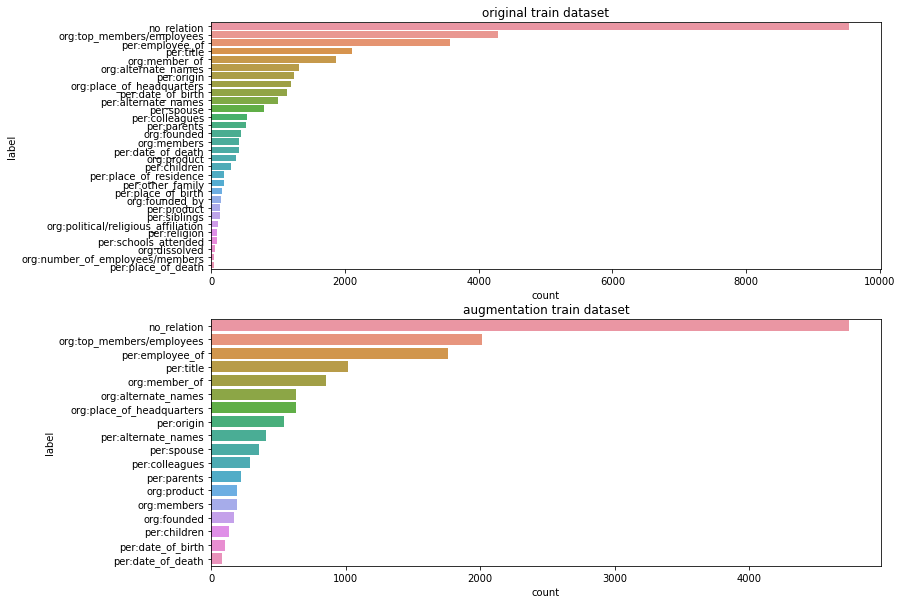

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12,10))

plt.subplot(2,1,1)
sns.countplot(y='label',data=train,order=train['label'].value_counts().index)
plt.title('original train dataset')

plt.subplot(2,1,2)
sns.countplot(y='label',data=sample,order=sample['label'].value_counts().index)
plt.title('augmentation train dataset')

plt.show()